In [1]:
import re
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import IFrame
import matplotlib.font_manager as fm

plt.style.use('ggplot')
%matplotlib inline
pd.options.display.max_columns=25

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Pulling the data

I will begin by pulling all the shot data from a single game. Below, in the url, one can see I have set the GameID=0021500051 (GSW vs. MEM on Nov. 2, 2015) and the TeamID=1610612744 (GSW). I will use requests library to get the the data from the url.

In [2]:
url = 'http://stats.nba.com/stats/shotchartdetail?'\
        'CFID=&CFPARAMS=&ContextFilter=&ContextMeasure=FGA'\
        '&Counter=1000&DateFrom=&DateTo=&Direction=DESC'\
        '&GameID=0021500051&GameSegment=&LastNGames=0&LeagueID=00'\
        '&Location=&Month=0&OpponentTeamID=0&Outcome=&Period=0'\
        '&PlayerID=0&PlayerOrTeam=T&Position=&RookieYear='\
        '&Season=2015-16&SeasonSegment=&SeasonType=Regular+Season'\
        '&Sorter=PTS&TeamID=1610612744&VsConference=&VsDivision='
response = requests.get(url)
response.json().keys()

[u'resource', u'resultSets', u'parameters']

This is similar to most returned jsons from stats.nba.com. The resource is the name of the resource I am accessing. In this case, it will be 'shotchartdetail'. The resultSets are the values that are returned to me containing the data I requested. The parameters are the relevant parameters issued for this request. Later in this notebook, I will make a request using these parameters in a dict and passing them as an argument in request.get().

Below I explore the keys returned and the relevant information.

In [3]:
resource = response.json()["resource"]
resultSets = response.json()["resultSets"]
parameters = response.json()["parameters"]
print resource
parameters

shotchartdetail


{u'AheadBehind': None,
 u'ClutchTime': None,
 u'ContextFilter': u'',
 u'ContextMeasure': u'FGA',
 u'DateFrom': None,
 u'DateTo': None,
 u'EndPeriod': None,
 u'EndRange': None,
 u'GameID': u'0021500051',
 u'GameSegment': None,
 u'LastNGames': 0,
 u'LeagueID': u'00',
 u'Location': None,
 u'Month': 0,
 u'OpponentTeamID': 0,
 u'Outcome': None,
 u'Period': 0,
 u'PlayerID': 0,
 u'PointDiff': None,
 u'Position': None,
 u'RangeType': None,
 u'RookieYear': None,
 u'Season': u'2015-16',
 u'SeasonSegment': None,
 u'SeasonType': u'Regular Season',
 u'StartPeriod': None,
 u'StartRange': None,
 u'TeamID': 1610612744,
 u'VsConference': None,
 u'VsDivision': None}

In [4]:
print type(resultSets)

<type 'list'>


In [5]:
print len(resultSets)

2


In [6]:
print [type(r) for r in resultSets]

[<type 'dict'>, <type 'dict'>]


In [7]:
print [r.keys() for r in resultSets]

[[u'headers', u'rowSet', u'name'], [u'headers', u'rowSet', u'name']]


In [8]:
[r['name'] for r in resultSets]

[u'Shot_Chart_Detail', u'LeagueAverages']

Great! This is like most resultSets returned from the stats.nba.com, where the first dict is the data on the player or team, and the second dict contains the league averages. Very useful!

Let's see what kind of data lies within 'Shot_Chart_Detail': 

In [9]:
resultSets[0]['headers']

[u'GRID_TYPE',
 u'GAME_ID',
 u'GAME_EVENT_ID',
 u'PLAYER_ID',
 u'PLAYER_NAME',
 u'TEAM_ID',
 u'TEAM_NAME',
 u'PERIOD',
 u'MINUTES_REMAINING',
 u'SECONDS_REMAINING',
 u'EVENT_TYPE',
 u'ACTION_TYPE',
 u'SHOT_TYPE',
 u'SHOT_ZONE_BASIC',
 u'SHOT_ZONE_AREA',
 u'SHOT_ZONE_RANGE',
 u'SHOT_DISTANCE',
 u'LOC_X',
 u'LOC_Y',
 u'SHOT_ATTEMPTED_FLAG',
 u'SHOT_MADE_FLAG']

In [10]:
resultSets[0]['rowSet'][0]

[u'Shot Chart Detail',
 u'0021500051',
 4,
 203084,
 u'Harrison Barnes',
 1610612744,
 u'Golden State Warriors',
 1,
 11,
 27,
 u'Missed Shot',
 u'Turnaround Jump Shot',
 u'2PT Field Goal',
 u'Mid-Range',
 u'Left Side(L)',
 u'8-16 ft.',
 11,
 -110,
 46,
 1,
 0]

Let's load the `resultSets[0]` into a dataframe using the header for column labels

In [11]:
sc_df = pd.DataFrame(resultSets[0]['rowSet'],columns=resultSets[0]['headers'])
sc_df.head(8)

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
0,Shot Chart Detail,0021500051,4,203084,Harrison Barnes,1610612744,Golden State Warriors,1,11,27,Missed Shot,Turnaround Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,11,-110,46,1,0
1,Shot Chart Detail,0021500051,11,201939,Stephen Curry,1610612744,Golden State Warriors,1,10,36,Made Shot,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,28,-210,188,1,1
2,Shot Chart Detail,0021500051,13,203110,Draymond Green,1610612744,Golden State Warriors,1,10,5,Made Shot,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,26,-173,203,1,1
3,Shot Chart Detail,0021500051,17,201939,Stephen Curry,1610612744,Golden State Warriors,1,9,34,Made Shot,Running Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,20,-160,120,1,1
4,Shot Chart Detail,0021500051,26,203084,Harrison Barnes,1610612744,Golden State Warriors,1,8,35,Missed Shot,Turnaround Jump Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,3,22,26,1,0
5,Shot Chart Detail,0021500051,29,201939,Stephen Curry,1610612744,Golden State Warriors,1,8,5,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,24,-20,247,1,0
6,Shot Chart Detail,0021500051,38,202691,Klay Thompson,1610612744,Golden State Warriors,1,7,25,Made Shot,Jump Shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,21,86,193,1,1
7,Shot Chart Detail,0021500051,43,202691,Klay Thompson,1610612744,Golden State Warriors,1,6,47,Made Shot,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),16-24 ft.,16,161,21,1,1


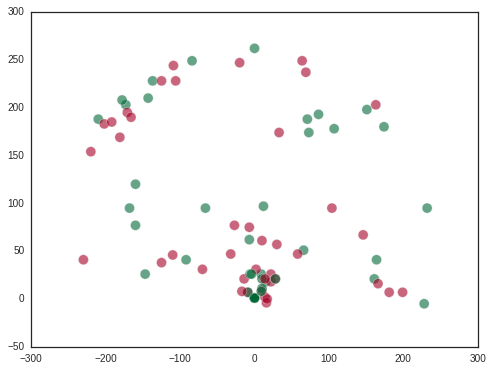

In [12]:
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(8, 6))
scat = plt.scatter(x=sc_df.LOC_X,y=sc_df.LOC_Y,c=sc_df.SHOT_MADE_FLAG,
    cmap=plt.cm.RdYlGn, s=100, alpha=.6)
plt.show()

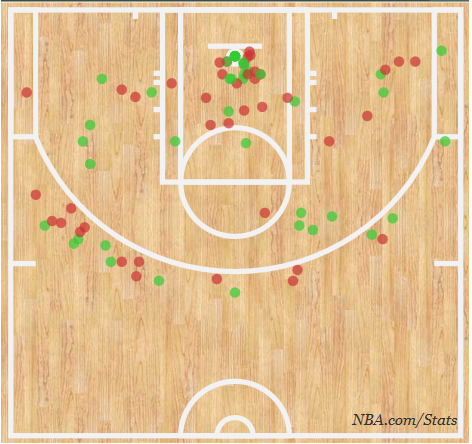

In [13]:
from IPython.display import Image
Image('img/example_nba_shotchart.png')

Okay, so we can see that the court is flipped on the NBA website. So I will flip my y-axis

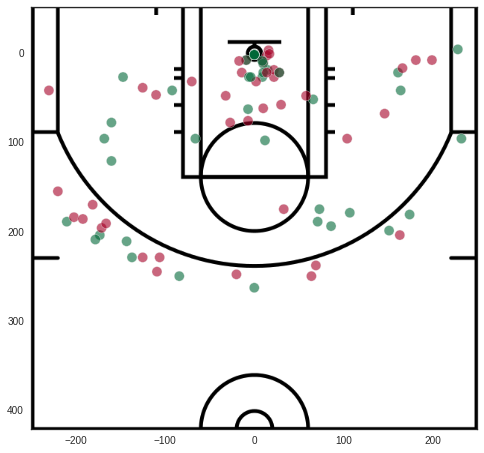

In [14]:
plt.style.use('seaborn-white')

fig,ax = plt.subplots(figsize=(8, 8))
scat = plt.scatter(x=sc_df.LOC_X,y=sc_df.LOC_Y,c=sc_df.SHOT_MADE_FLAG,
    cmap=plt.cm.RdYlGn, s=100, alpha=.6, zorder=1)
ax.invert_yaxis()

plt.style.use('grayscale')
#Read in the half court image
court = plt.imread("img/halfcourt.png")
#The baseline is 4 ft. from front of backboard. front of backboard is 15 in. from center of hoop (the origin).
#Therefore, my image extent needs to go from (4ft.+15in.) = 5.25 ft. so 52.5 ft. in the coordinate system.
img = plt.imshow(court, zorder=0, extent=[-250,250,420,-52.5])

plt.show()

Great, I can make sense and plot the data from nba.com.  Now I will get shot data for all players for the 2015-16 season and determine the best shooter from each zone.

Steps
1. Pull shot data for all players
2. Parse the data into a table with rows of players, columns of zone1_attempts zone1_made, etc.
3. Calculate best for each zone

Below, I expose a bit more about the nba stats API. I setup a dict of the required parameters to the shotchartdetail call. I set TeamID, GameID, and PlayerID to 0. With Season set to 2015-16, I will pull all the shot data for the regular season so far. Initially, I was going to pull each player with separate calls, but this is much better (and makes a lot fewer requests for the site).

In [15]:
sc_params = {u'AheadBehind': u'',
 u'ClutchTime': u'',
 u'ContextFilter': u'',
 u'ContextMeasure': u'FGA',
 u'DateFrom': u'',
 u'DateTo': u'',
 u'EndPeriod': u'',
 u'EndRange': u'',
 u'GameID': u'',
 u'GameSegment': u'',
 u'LastNGames': 0,
 u'LeagueID': u'00',
 u'Location': u'',
 u'Month': 0,
 u'OpponentTeamID': 0,
 u'Outcome': u'',
 u'Period': 0,
 u'PlayerID': 0,
 u'PointDiff': u'',
 u'Position': u'',
 u'RangeType': u'',
 u'RookieYear': u'',
 u'Season': u'2015-16',
 u'SeasonSegment': u'',
 u'SeasonType': u'Regular Season',
 u'StartPeriod': u'',
 u'StartRange': u'',
 u'TeamID': 0,
 u'VsConference': u'',
 u'VsDivision': u''}

baseurl = 'http://stats.nba.com/stats/shotchartdetail?'
resp2 = requests.get(baseurl,params=sc_params)
print resp2.url
print resp2.json().keys()

http://stats.nba.com/stats/shotchartdetail?PlayerID=0&StartPeriod=&StartRange=&TeamID=0&VsConference=&Location=&SeasonType=Regular+Season&RangeType=&RookieYear=&Season=2015-16&DateFrom=&ClutchTime=&EndPeriod=&EndRange=&ContextFilter=&GameID=&OpponentTeamID=0&DateTo=&GameSegment=&AheadBehind=&PointDiff=&LastNGames=0&VsDivision=&LeagueID=00&Position=&Outcome=&ContextMeasure=FGA&SeasonSegment=&Period=0&Month=0
[u'resource', u'resultSets', u'parameters']


In [16]:
player_shot_df = pd.DataFrame(resp2.json()['resultSets'][0]['rowSet'],columns=resp2.json()['resultSets'][0]['headers'])
print player_shot_df.shape
player_shot_df.head(5)

(42578, 21)


,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
0,Shot Chart Detail,0021500001,2,203083,Andre Drummond,1610612765,Detroit Pistons,1,11,41,Missed Shot,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,-17,-6,1,0
1,Shot Chart Detail,0021500001,5,202694,Marcus Morris,1610612765,Detroit Pistons,1,11,21,Made Shot,Step Back Jump shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,13,117,67,1,1
2,Shot Chart Detail,0021500001,6,200794,Paul Millsap,1610612737,Atlanta Hawks,1,11,0,Made Shot,Step Back Jump shot,2PT Field Goal,In The Paint (Non-RA),Right Side(R),8-16 ft.,12,76,95,1,1
3,Shot Chart Detail,0021500001,7,203484,Kentavious Caldwell-Pope,1610612765,Detroit Pistons,1,10,44,Made Shot,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Left Side(L),8-16 ft.,8,-68,51,1,1
4,Shot Chart Detail,0021500001,8,201143,Al Horford,1610612737,Atlanta Hawks,1,10,27,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,20,-117,164,1,0


### Plot all the shots

Now, I will plot all of the shots so far this season. I changed the court to be black and used yellow for the made shots and blue for the misses. This makes the misses stand out more, and is more color-blind friendly than red/green plots.

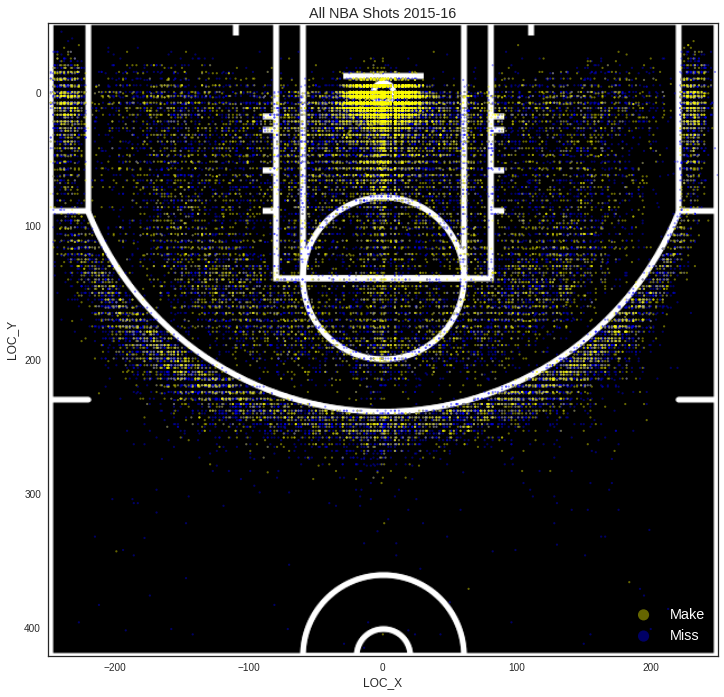

In [17]:
plt.style.use('seaborn-white')
fig,ax = plt.subplots(figsize=(12, 12))

keepxy = ['LOC_X','LOC_Y']
made_index = (player_shot_df['SHOT_MADE_FLAG']==1)
made_df = player_shot_df.loc[made_index][keepxy]
miss_df = player_shot_df.loc[~made_index][keepxy]

made_df.plot(kind='scatter', x='LOC_X',y='LOC_Y',color='Yellow',
             s=5, alpha=.4, edgecolors='none', zorder=2,ax=ax,
            label='Make')
miss_df.plot(kind='scatter', x='LOC_X',y='LOC_Y',color='Blue',
             s=5, alpha=.4, edgecolors='none', zorder=1,ax=ax,
            label='Miss')
                             
ax.invert_yaxis()

# Set legend to lower right, x-large text, and larger markerscale
leg = ax.legend(loc='lower right',fontsize='x-large',markerscale=5)
labls = leg.get_texts()
[x.set_color('white') for x in labls]

#Read in the half court image
court = plt.imread("img/halfcourt.png")
#The baseline is 4 ft. from front of backboard. front of backboard is 15 in. from center of hoop (the origin).
#Therefore, my image extent needs to go from (4ft.+15in.) = 5.25 ft. so 52.5 ft. in the coordinate system.
img = plt.imshow(court, zorder=0, extent=[-250,250,420,-52.5])

plt.title('All NBA Shots 2015-16',fontsize='x-large')
plt.savefig('img/NBA_shotchart_2015-16.png',dpi=300)
plt.show()

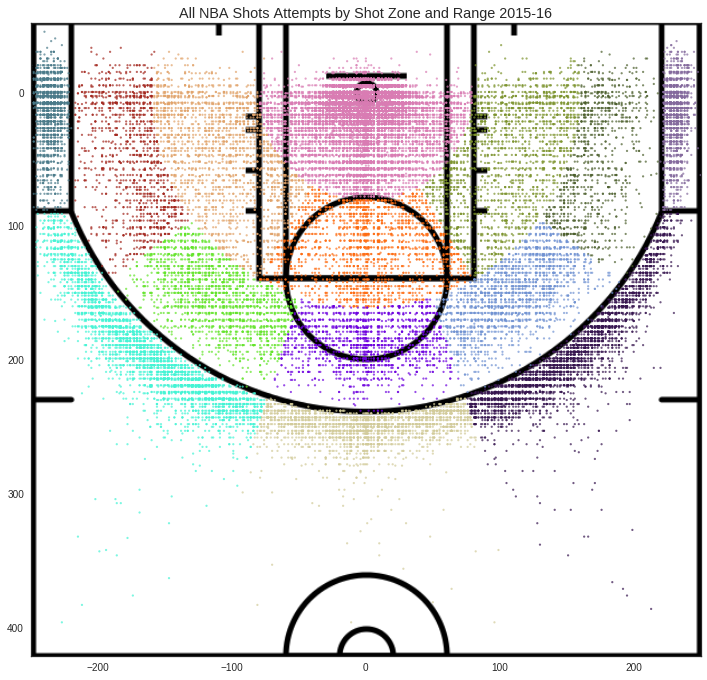

In [18]:
ZAs = player_shot_df.SHOT_ZONE_AREA.unique()
ZRs = player_shot_df.SHOT_ZONE_RANGE.unique()[:-1] #-1 to avoid Backcourt shots

fig,ax = plt.subplots(figsize=(12, 12))
colrs = np.random.random((len(ZAs)*len(ZRs),4))

cnum=0
for za in ZAs:
    for zr in ZRs:
        bin_mask = (player_shot_df['SHOT_ZONE_AREA']==za) & (player_shot_df['SHOT_ZONE_RANGE']==zr)
        if np.sum(bin_mask) > 0:
            cnum+=1
            plt.scatter(x=player_shot_df[bin_mask]['LOC_X'],y=player_shot_df[bin_mask]['LOC_Y'],c=colrs[cnum],
             s=5, alpha=.7, edgecolors='none', zorder=2,label=za+zr)
ax.invert_yaxis()

#Read in the half court image
plt.style.use('grayscale')
court = plt.imread("img/halfcourt.png")
#The baseline is 4 ft. from front of backboard. front of backboard is 15 in. from center of hoop (the origin).
#Therefore, my image extent needs to go from (4ft.+15in.) = 5.25 ft. so 52.5 ft. in the coordinate system.
img = plt.imshow(court, zorder=0, extent=[-250,250,420,-52.5])
plt.title('All NBA Shots Attempts by Shot Zone and Range 2015-16',fontsize='x-large')
plt.savefig('img/NBA_shotzonerange_2015-16.png',dpi=300)
plt.show()

Close enough. The out-of-bounds lines are actually inside the bounds of the court. I can work on drawing the court very carefully in another notebook.

Here is a summary of shot types (2pt,3pt), shot zone areas (L,LC,C,RC,L), and shot zone ranges (<8,8-16,16-24,>24)

In [20]:
keepfields=['SHOT_TYPE','SHOT_ZONE_AREA','SHOT_ZONE_RANGE','SHOT_ATTEMPTED_FLAG','SHOT_MADE_FLAG']
shot_type_zone_df = player_shot_df[keepfields].groupby(['SHOT_TYPE','SHOT_ZONE_AREA']).sum()
shot_type_zone_df = shot_type_zone_df.assign(SHOT_MADE_PCT = shot_type_zone_df['SHOT_MADE_FLAG']/shot_type_zone_df['SHOT_ATTEMPTED_FLAG'])
shot_type_zone_df

SHOT_ATTEMPTED_FLAG  SHOT_MADE_FLAG  \
SHOT_TYPE      SHOT_ZONE_AREA                                               
2PT Field Goal Center(C)                            21081           10973   
               Left Side Center(LC)                  1717             684   
               Left Side(L)                          3165            1211   
               Right Side Center(RC)                 1759             683   
               Right Side(R)                         2878            1096   
3PT Field Goal Back Court(BC)                         100               5   
               Center(C)                             2181             746   
               Left Side Center(LC)                  3461            1163   
               Left Side(L)                          1549             592   
               Right Side Center(RC)                 3215            1137   
               Right Side(R)                         1472             526   

                                      SHOT_MADE_PCT  
SHOT_TYPE      SHOT_ZONE_AREA                        
2PT Field Goal Center(C)                   0.520516  
               Left Side Center(LC)        0.398369  
               Left Side(L)                0.382622  
               Right Side Center(RC)       0.388289  
               Right Side(R)               0.380820  
3PT Field Goal Back Court(BC)              0.050000  
               Center(C)                   0.342045  
               Left Side Center(LC)        0.336030  
               Left Side(L)                0.382182  
               Right Side Center(RC)       0.353655  
               Right Side(R)               0.357337

__NOTE:__ An earlier version had a 2PT back court shot. It has since been corrected in the nba stats database. I leave the next few lines here because it won't effect the data and stands as a reminder to check data and correct it.

Hmm. A 2 PT back court shot? I can't think of a scenario where that could occur.
I will investigate and clean this up.

In [21]:
bad_code = player_shot_df[(player_shot_df['SHOT_TYPE']=='2PT Field Goal') & (player_shot_df['SHOT_ZONE_AREA']=='Back Court(BC)')]
bad_code

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG


In [22]:
#It is clearly a 3PT shot (based on distance, x, and y)
player_shot_df.loc[bad_code.index,'SHOT_TYPE']='3PT Field Goal'
#See if any shots with distance > 24 ft. are marked as 2 PT
player_shot_df[(player_shot_df['SHOT_TYPE']=='2PT Field Goal') & (player_shot_df['SHOT_DISTANCE']>=24)]

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG


I will examine some other fields to make sure things are in order.

In [23]:
player_shot_df['ACTION_TYPE'].value_counts()

Jump Shot                             20941
Layup Shot                             3981
Driving Layup Shot                     2515
Pullup Jump shot                       2185
Floating Jump shot                     1091
Hook Shot                               901
Step Back Jump shot                     894
Tip Layup Shot                          838
Turnaround Jump Shot                    743
Running Layup Shot                      734
Dunk Shot                               655
Cutting Layup Shot                      617
Fadeaway Jump Shot                      546
Running Jump Shot                       519
Putback Layup Shot                      425
Reverse Layup Shot                      409
Driving Finger Roll Layup Shot          403
Jump Bank Shot                          385
Turnaround Hook Shot                    333
Driving Floating Jump Shot              311
Driving Reverse Layup Shot              288
Alley Oop Dunk Shot                     267
Turnaround Fadeaway shot        

What a mess! Just some of the issues here:
* seems to be a lot of 'Driving' and 'Running' shots with very little difference between them
* 'No Shot' shots? That can't be correct
* [sS]hot needs to be standardized
* Some descriptives seem very subjective

Use some regex to clean it up and see the proportions of each action type

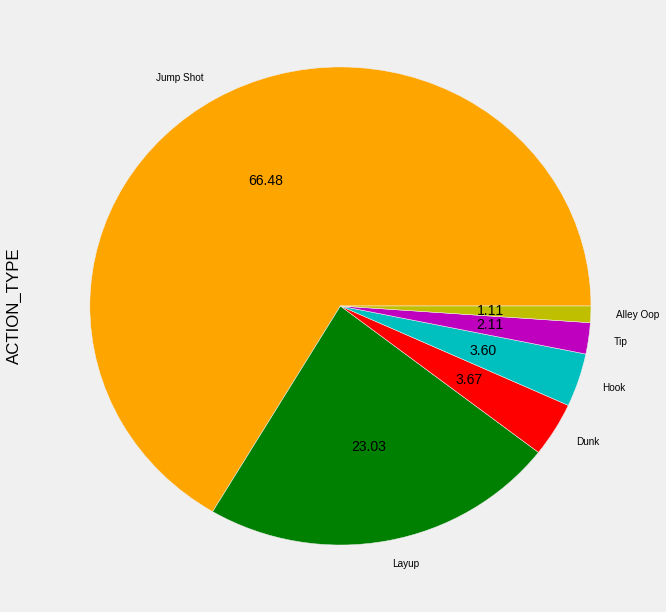

In [24]:
import re
from collections import OrderedDict

def clean_action_type(text):
    text=re.sub(u'shot',u'Shot',text)
    text=re.sub(u'Driving |Running |Cutting ',u'',text)
    text=re.sub(u'Pullup |Pull-Up |Step Back |Turnaround |Putback |Floating |Finger Roll |Reverse ',u'',text)
    text=re.sub(u'Tip Layup Shot|Tip Dunk Shot',u'Tip',text)
    text=re.sub(u'Alley Oop Dunk Shot|Alley Oop Layup Shot',u'Alley Oop',text)
    text=re.sub(u'Fadeaway Shot|Fadeaway Bank Shot|Fadeaway Bank Jump Shot',u'Fadeaway Jump Shot',text)
    text=re.sub(u'Bank Jump Shot|Jump Bank Shot|Bank Shot|Fadeaway Jump Shot',u'Jump Shot',text)
    text=re.sub(u'Bank Hook Shot|Hook Bank Shot|Hook Jump Shot',u'Hook Shot',text)
    return text

def categorize_action_type(text):
    keywords = OrderedDict()
    keywords["Alley Oop"] = ["Alley Oop"] #alley oop first (so alley oop dunks -> alley oop and not dunk)
    keywords["Tip"] = ["Tip"] #tip next
    keywords["Dunk"] = ["Dunk"]
    keywords["Layup"] = ["Layup"]
    keywords["Hook"] = ["Hook"]
    keywords["Jump Shot"] = ["Jump","Fadeaway"]
    
    keywords_res = OrderedDict()
    for k in keywords:
        pat = "\\b%s\\b" % "\\b|\\b".join(keywords[k])
        keywords_res[k] = re.compile(pat, re.IGNORECASE)
    
    for r in keywords_res:
        if keywords_res[r].search(text): return r
    return "Other"
    
#action_counts = player_shot_df['ACTION_TYPE'].map(lambda x: clean_action_type(x)).value_counts()
action_counts = player_shot_df['ACTION_TYPE'].map(lambda x: categorize_action_type(x)).value_counts()

#plt.style.use('seaborn-white')
plt.style.use('fivethirtyeight')

#action_counts.drop('No Shot').plot(kind='pie',figsize=(8,8),autopct='%.2f',colors=['b','g','r','c','m','y','gray','orange'])
action_counts.drop('Other').plot(kind='pie',figsize=(10,10),autopct='%.2f',colors=['orange','g','r','c','m','y','gray'])

Unsurprisingly, jump shots are most common.

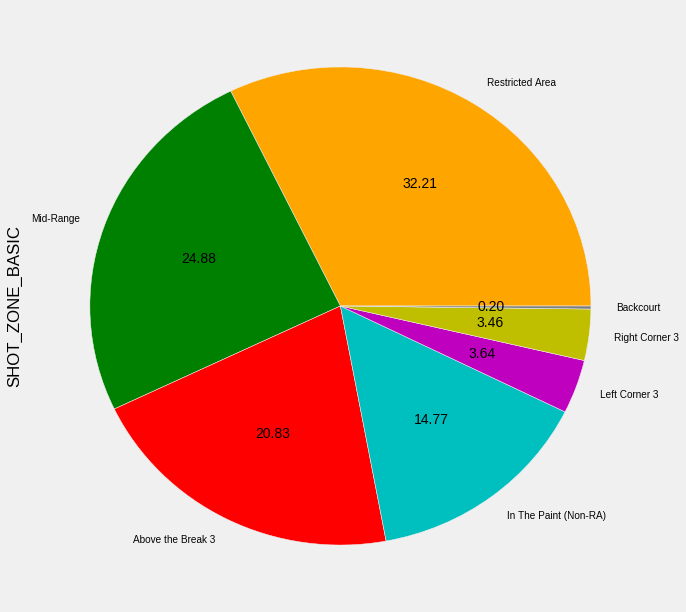

In [25]:
player_shot_df['SHOT_ZONE_BASIC'].value_counts().plot(kind='pie',figsize=(10,10),autopct='%.2f',colors=['orange','g','r','c','m','y','gray'])

### No shot

To see what is going on with the 'No Shot' action types, I will filter the data frame.

In [26]:
player_shot_df[player_shot_df['ACTION_TYPE']=='No Shot']

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
17572,Shot Chart Detail,0021500104,34,203105,Festus Ezeli,1610612744,Golden State Warriors,1,6,51,Made Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,1,1,1
17574,Shot Chart Detail,0021500104,37,202704,Reggie Jackson,1610612765,Detroit Pistons,1,6,23,Made Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,10,7,1,1
17582,Shot Chart Detail,0021500104,59,101106,Andrew Bogut,1610612744,Golden State Warriors,1,4,16,Missed Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,-7,21,1,0
17583,Shot Chart Detail,0021500104,61,101106,Andrew Bogut,1610612744,Golden State Warriors,1,4,14,Made Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,-4,7,1,1
17607,Shot Chart Detail,0021500104,135,2733,Shaun Livingston,1610612744,Golden State Warriors,2,8,35,Missed Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,-9,2,1,0
17617,Shot Chart Detail,0021500104,168,201578,Marreese Speights,1610612744,Golden State Warriors,2,6,23,Missed Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,6,13,1,0
17619,Shot Chart Detail,0021500104,173,203382,Aron Baynes,1610612765,Detroit Pistons,2,6,10,Missed Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,3,0,1,0
17683,Shot Chart Detail,0021500104,351,101106,Andrew Bogut,1610612744,Golden State Warriors,3,1,50,Missed Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,1,4,1,0
17684,Shot Chart Detail,0021500104,353,101106,Andrew Bogut,1610612744,Golden State Warriors,3,1,49,Made Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,1,7,1,1
17688,Shot Chart Detail,0021500104,367,101106,Andrew Bogut,1610612744,Golden State Warriors,3,0,48,Made Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,-11,16,1,1


These are games from the same recent night, that perhaps have not yet been correctly coded. To view them, I will write out links to the video of each event. 

In [27]:
def game_event_id_video_link(gid,gevid):
    if isinstance(gid,int):
        gid = str(gid)
    if isinstance(gevid,int):
        gevid = str(gevid)
    return 'http://stats.nba.com/cvp.html?GameID='+gid+'&GameEventID='+gevid

for f,row in player_shot_df[player_shot_df['ACTION_TYPE']=='No Shot'].iterrows():
    print game_event_id_video_link(row['GAME_ID'],row['GAME_EVENT_ID'])

http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=34
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=37
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=59
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=61
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=135
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=168
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=173
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=351
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=353
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=367
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=456
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=483
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=476
http://stats.nba.com/cvp.html?GameID=0021500105&GameEventID=11
http://stats.nba.com/cvp.html?GameID=0021500105&GameEventID=23
http://stats.nba.com/cvp.html?GameID=002150010

Looking at them, these 'No Shots' are actual shots (dunks,layups,etc.). I'll remove the 'No Shot's from any plots that use it. Otherwise, the other data appears to be correct (x and y loc, areas), so I will keep it in. If I was going to do something serious with the action types, I could code them myself by watching the videos. 

### Top 10 FG% per shot zone
I will apply a groupby function on the data to parse out the number of made and number of attempted shots for each shot zone, for each player.

In [28]:
keepfields = ['PLAYER_ID','PLAYER_NAME','TEAM_NAME','SHOT_TYPE','SHOT_ZONE_AREA','SHOT_ZONE_RANGE','SHOT_ATTEMPTED_FLAG','SHOT_MADE_FLAG']
shot_zones_df=player_shot_df[keepfields].groupby(['PLAYER_ID','PLAYER_NAME','TEAM_NAME','SHOT_TYPE','SHOT_ZONE_AREA','SHOT_ZONE_RANGE']).sum()
shot_zones_df.head(15)

SHOT_ATTEMPTED_FLAG  \
PLAYER_ID PLAYER_NAME   TEAM_NAME              SHOT_TYPE      SHOT_ZONE_AREA        SHOT_ZONE_RANGE                        
708       Kevin Garnett Minnesota Timberwolves 2PT Field Goal Center(C)             16-24 ft.                          4   
                                                                                    8-16 ft.                           3   
                                                                                    Less Than 8 ft.                   11   
                                                              Left Side Center(LC)  16-24 ft.                          6   
                                                              Left Side(L)          16-24 ft.                          4   
                                                                                    8-16 ft.                           3   
                                                              Right Side Center(RC) 16-24 ft.                          7   
                                                              Right Side(R)         16-24 ft.                          4   
                                                                                    8-16 ft.                           2   
977       Kobe Bryant   Los Angeles Lakers     2PT Field Goal Center(C)             16-24 ft.                          9   
                                                                                    8-16 ft.                           8   
                                                                                    Less Than 8 ft.                   35   
                                                              Left Side Center(LC)  16-24 ft.                         11   
                                                              Left Side(L)          16-24 ft.                          5   
                                                                                    8-16 ft.                          18   

                                                                                                     SHOT_MADE_FLAG  
PLAYER_ID PLAYER_NAME   TEAM_NAME              SHOT_TYPE      SHOT_ZONE_AREA        SHOT_ZONE_RANGE                  
708       Kevin Garnett Minnesota Timberwolves 2PT Field Goal Center(C)             16-24 ft.                     3  
                                                                                    8-16 ft.                      3  
                                                                                    Less Than 8 ft.               6  
                                                              Left Side Center(LC)  16-24 ft.                     2  
                                                              Left Side(L)          16-24 ft.                     2  
                                                                                    8-16 ft.                      0  
                                                              Right Side Center(RC) 16-24 ft.                     2  
                                                              Right Side(R)         16-24 ft.                     2  
                                                                                    8-16 ft.                      0  
977       Kobe Bryant   Los Angeles Lakers     2PT Field Goal Center(C)             16-24 ft.                     5  
                                                                                    8-16 ft.                      2  
                                                                                    Less Than 8 ft.              18  
                                                              Left Side Center(LC)  16-24 ft.                     1  
                                                              Left Side(L)          16-24 ft.                     2  
                                                                                    8-16 ft.            

Now mask for at least 10 shot attempts, and calculate FG%.

In [29]:
mask = shot_zones_df['SHOT_ATTEMPTED_FLAG']>=10
shot_zones_df = shot_zones_df.loc[mask]
#now create 'SHOT_MADE_FLAG' column using the assign function
shot_zones_df = shot_zones_df.assign(FG_PCT = shot_zones_df['SHOT_MADE_FLAG']/shot_zones_df['SHOT_ATTEMPTED_FLAG'])
shot_zones_df.head(5)

SHOT_ATTEMPTED_FLAG  \
PLAYER_ID PLAYER_NAME   TEAM_NAME              SHOT_TYPE      SHOT_ZONE_AREA        SHOT_ZONE_RANGE                        
708       Kevin Garnett Minnesota Timberwolves 2PT Field Goal Center(C)             Less Than 8 ft.                   11   
977       Kobe Bryant   Los Angeles Lakers     2PT Field Goal Center(C)             Less Than 8 ft.                   35   
                                                              Left Side Center(LC)  16-24 ft.                         11   
                                                              Left Side(L)          8-16 ft.                          18   
                                                              Right Side Center(RC) 16-24 ft.                         21   

                                                                                                     SHOT_MADE_FLAG  \
PLAYER_ID PLAYER_NAME   TEAM_NAME              SHOT_TYPE      SHOT_ZONE_AREA        SHOT_ZONE_RANGE                   
708       Kevin Garnett Minnesota Timberwolves 2PT Field Goal Center(C)             Less Than 8 ft.               6   
977       Kobe Bryant   Los Angeles Lakers     2PT Field Goal Center(C)             Less Than 8 ft.              18   
                                                              Left Side Center(LC)  16-24 ft.                     1   
                                                              Left Side(L)          8-16 ft.                      5   
                                                              Right Side Center(RC) 16-24 ft.                     8   

                                                                                                       FG_PCT  
PLAYER_ID PLAYER_NAME   TEAM_NAME              SHOT_TYPE      SHOT_ZONE_AREA        SHOT_ZONE_RANGE            
708       Kevin Garnett Minnesota Timberwolves 2PT Field Goal Center(C)             Less Than 8 ft.  0.545455  
977       Kobe Bryant   Los Angeles Lakers     2PT Field Goal Center(C)             Less Than 8 ft.  0.514286  
                                                              Left Side Center(LC)  16-24 ft.        0.090909  
                                                              Left Side(L)          8-16 ft.         0.277778  
                                                              Right Side Center(RC) 16-24 ft.        0.380952

### Top 10 League Leaders in Shots Made from each Shot Zone
Currently masked at 10 attempts for early in the season. This should be modified later in the season.

In [30]:
idx=pd.IndexSlice
print '===== 2PT FGS ====='
print '2PT FGS < 8 ft. ======='
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Center(C)'],['Less Than 8 ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]
print '\n2PT FGS 8-16 ft. ======='
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Right Side(R)'],['8-16 ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Center(C)'],['8-16 ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Left Side(L)'],['8-16 ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]
print '\n2PT FGS 16-24 ft. ======='
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Right Side(R)'],['16-24 ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Right Side Center(RC)'],['16-24 ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Center(C)'],['16-24 ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Left Side Center(LC)'],['16-24 ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Left Side(L)'],['16-24 ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]

print '\n===== 3PT FGS ====='
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Right Side(R)'],['24+ ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Right Side Center(RC)'],['24+ ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Center(C)'],['24+ ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Left Side Center(LC)'],['24+ ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Left Side(L)'],['24+ ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]

===== 2PT FGS =====
2PT FGS < 8 ft. =======
                                                                                                     SHOT_MADE_FLAG
PLAYER_ID PLAYER_NAME           TEAM_NAME             SHOT_TYPE      SHOT_ZONE_AREA SHOT_ZONE_RANGE                
203083    Andre Drummond        Detroit Pistons       2PT Field Goal Center(C)      Less Than 8 ft.             126
2544      LeBron James          Cleveland Cavaliers   2PT Field Goal Center(C)      Less Than 8 ft.             109
1626143   Jahlil Okafor         Philadelphia 76ers    2PT Field Goal Center(C)      Less Than 8 ft.             104
201152    Thaddeus Young        Brooklyn Nets         2PT Field Goal Center(C)      Less Than 8 ft.              98
202328    Greg Monroe           Milwaukee Bucks       2PT Field Goal Center(C)      Less Than 8 ft.              97
201933    Blake Griffin         Los Angeles Clippers  2PT Field Goal Center(C)      Less Than 8 ft.              97
203507    Giannis Antetokoun

### Top 10 League Leaders in FG% from each Shot Zone
Currently masked at 10 attempts for early in the season. This should be modified later in the season.

In [31]:
idx=pd.IndexSlice
print '===== 2PT FGS ====='
print '2PT FGS < 8 ft. ======='
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Center(C)'],['Less Than 8 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print '\n2PT FGS 8-16 ft. ======='
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Right Side(R)'],['8-16 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Center(C)'],['8-16 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Left Side(L)'],['8-16 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print '\n2PT FGS 16-24 ft. ======='
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Right Side(R)'],['16-24 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Right Side Center(RC)'],['16-24 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Center(C)'],['16-24 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Left Side Center(LC)'],['16-24 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Left Side(L)'],['16-24 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]

print '\n===== 3PT FGS ====='
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Right Side(R)'],['24+ ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Right Side Center(RC)'],['24+ ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Center(C)'],['24+ ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Left Side Center(LC)'],['24+ ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Left Side(L)'],['24+ ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]

===== 2PT FGS =====
2PT FGS < 8 ft. =======
                                                                                                   FG_PCT
PLAYER_ID PLAYER_NAME       TEAM_NAME             SHOT_TYPE      SHOT_ZONE_AREA SHOT_ZONE_RANGE          
202325    Wesley Johnson    Los Angeles Clippers  2PT Field Goal Center(C)      Less Than 8 ft.  0.866667
1626149   Montrezl Harrell  Houston Rockets       2PT Field Goal Center(C)      Less Than 8 ft.  0.740741
101106    Andrew Bogut      Golden State Warriors 2PT Field Goal Center(C)      Less Than 8 ft.  0.740000
1717      Dirk Nowitzki     Dallas Mavericks      2PT Field Goal Center(C)      Less Than 8 ft.  0.736842
1626147   Justin Anderson   Dallas Mavericks      2PT Field Goal Center(C)      Less Than 8 ft.  0.727273
203118    Mike Scott        Atlanta Hawks         2PT Field Goal Center(C)      Less Than 8 ft.  0.718750
201148    Brandan Wright    Memphis Grizzlies     2PT Field Goal Center(C)      Less Than 8 ft.  0.714286
22

### Wrapping up

I have shown how to query, parse, and plot shot chart data from stats.nba.com. There is so much to do with this data! A few ideas:

* A visualization of the best shooter for each shot zone
* Cluster shot attempts to find shooting zones


It is still too early in the season to have reliable measures for FG%. In a following notebook, I will conduct some measures to determine the number of shot attempts until FG% is reliable.
